##### import libraries

In [1]:
import pickle
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import mne

##### load features

In [2]:
def load_pickle_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

coh_base_dir = '../data/COH/'  
pli_base_dir = '../data/PLI/' 
ste_base_dir = '../data/STE/'

HC_coh = load_pickle_data(coh_base_dir + 'HC_coh_data.pkl')
HC_pli = load_pickle_data(pli_base_dir + 'HC_pli_data.pkl')
MDD_coh = load_pickle_data(coh_base_dir + 'MDD_coh_data.pkl')
MDD_pli = load_pickle_data(pli_base_dir + 'MDD_pli_data.pkl')
HC_ste  = load_pickle_data(ste_base_dir + 'HC_ste_data.pkl')
MDD_ste = load_pickle_data(ste_base_dir + 'MDD_ste_data.pkl')

In [3]:
def combine_features(subject_id, coh_dict, pli_dict):

    frequency_bands = ['delta', 'theta', 'alpha', 'betalow', 'betahigh', 'gamma']
    features = []
    for band in frequency_bands:
        features.append(coh_dict[subject_id][band])
    for band in frequency_bands:
        features.append(pli_dict[subject_id][band])
    return np.concatenate(features)

In [4]:
def combine_features_all(subject_id, coh_dict, pli_dict, ste_dict):

    frequency_bands = ['delta', 'theta', 'alpha', 'betalow', 'betahigh', 'gamma']
    features = []

    for band in frequency_bands:
        features.append(coh_dict[subject_id][band])

    for band in frequency_bands:
        features.append(pli_dict[subject_id][band])

    for band in frequency_bands:
        matrix = ste_dict[subject_id][band]  # shape: (29, 29)
        mask = np.ones(matrix.shape, dtype=bool)
        np.fill_diagonal(mask, False)
        vector = matrix[mask]                #  29*29 - 29 = 812
        features.append(vector)

    return np.concatenate(features)

In [5]:
HC_subjects = sorted(HC_coh.keys())
MDD_subjects = sorted(MDD_coh.keys())

n_train_HC = 45
n_train_MDD = 45

HC_train_ids = HC_subjects[:n_train_HC]
HC_test_ids  = HC_subjects[n_train_HC:]
MDD_train_ids = MDD_subjects[:n_train_MDD]
MDD_test_ids  = MDD_subjects[n_train_MDD:]

In [6]:
X_train_list = []
y_train_list = []
train_ids = []

for subj in HC_train_ids:
    feat_vector = combine_features_all(subj, HC_coh, HC_pli, HC_ste)
    X_train_list.append(feat_vector)
    y_train_list.append(0)   # HC label as 0
    train_ids.append(subj)
    
for subj in MDD_train_ids:
    feat_vector = combine_features_all(subj, MDD_coh, MDD_pli, MDD_ste)
    X_train_list.append(feat_vector)
    y_train_list.append(1)   # MDD label as 1
    train_ids.append(subj)

X_train = np.array(X_train_list)   # shape: (90, 4872)
y_train = np.array(y_train_list)

print("training set data shape:", X_train.shape, y_train.shape)

training set data shape: (90, 9744) (90,)


In [7]:
X_test_list = []
y_test_list = []
test_ids = []

for subj in HC_test_ids:
    feat_vector = combine_features_all(subj, HC_coh, HC_pli, HC_ste)
    X_test_list.append(feat_vector)
    y_test_list.append(0)
    test_ids.append(subj)
    
for subj in MDD_test_ids:
    feat_vector = combine_features_all(subj, MDD_coh, MDD_pli, MDD_ste)
    X_test_list.append(feat_vector)
    y_test_list.append(1)
    test_ids.append(subj)

X_test = np.array(X_test_list)     # shape: (39, 4872)
y_test = np.array(y_test_list)

print("independent test set data shape:", X_test.shape, y_test.shape)

independent test set data shape: (46, 9744) (46,)


##### Fisher score

In [8]:
def compute_fisher_scores(X, y, eps=1e-12):
    N = len(y)  
    n_class0 = np.sum(y == 0)
    n_class1 = np.sum(y == 1)
    p0 = n_class0 / N
    p1 = n_class1 / N
    
    m_global = np.mean(X, axis=0)   # (n_features,)
    
    X_class0 = X[y == 0]
    X_class1 = X[y == 1]
    m0 = np.mean(X_class0, axis=0)
    m1 = np.mean(X_class1, axis=0)
    
    var0 = np.var(X_class0, axis=0)
    var1 = np.var(X_class1, axis=0)
    
    
    S_B = p0 * (m0 - m_global)**2 + p1 * (m1 - m_global)**2
    S_W = p0 * var0 + p1 * var1
    
    Fscore = S_B / (S_W + eps)
    return Fscore


fscores = compute_fisher_scores(X_train, y_train)
top_100_idx = np.argsort(fscores)[-100:]
top_100_idx = top_100_idx[np.argsort(fscores[top_100_idx])[::-1]]

X_train_reduced = X_train[:, top_100_idx]
X_test_reduced  = X_test[:,  top_100_idx]

print("training set data shape:", X_train_reduced.shape)
print("independent test set data shape:",  X_test_reduced.shape)
# print("Top 100 feature indices：", top_100_idx)


training set data shape: (90, 100)
independent test set data shape: (46, 100)


##### SFS + LOPO CV + Grid Search 

In [9]:
def SFS_select(X, y, max_steps, param_grid=None, verbose=True):

    if param_grid is None:
        param_grid = {'C': [1, 10], 'gamma': [0.01, 0.1]}
    
    cv_obj = LeaveOneOut()
    
    
    def evaluate_subset(feature_indices):
        X_sub = X[:, feature_indices]
        svc = SVC()
        grid = GridSearchCV(estimator=svc,
                            param_grid=param_grid,
                            scoring='accuracy',
                            cv=cv_obj,
                            n_jobs=-1)
        grid.fit(X_sub, y)
        return grid.best_score_, grid.best_params_
    
    candidate_features = list(range(X.shape[1]))  # (Ns = 100)
    selected = []       
    history = []        
    
    best_overall = {'subset': None, 'cv_score': -1, 'best_params': None, 'step': None}
    
    # start from 1 to max_steps
    for step in range(1, max_steps + 1):
        if verbose:
            print(f"\n[SFS] Step {step}: current subset = {selected}")
        best_feature = None
        best_score = -1
        best_params = None
        best_candidate_subset = None
        
        # Run through all candidate features
        for f in candidate_features:
            if f in selected:
                continue
            candidate_subset = selected + [f]
            score, params = evaluate_subset(candidate_subset)
            if verbose:
                print(f"Tested subset candidate {candidate_subset} -> CV Accuracy = {score:.4f}")
            if score > best_score:
                best_score = score
                best_feature = f
                best_params = params
                best_candidate_subset = candidate_subset.copy()
                
        # Put the best feature into the selected list
        selected.append(best_feature)
        step_record = {
            'step': step,
            'subset': selected.copy(),
            'cv_score': best_score,
            'best_params': best_params
        }
        history.append(step_record)
        if verbose:
            print(f"--> Step {step} Selected features {best_feature}，Current subset = {selected}，CV Accuracy = {best_score:.4f}")
        
        # If the best score is better than the overall best, update the overall best
        if best_score > best_overall['cv_score']:
            best_overall['subset'] = selected.copy()
            best_overall['cv_score'] = best_score
            best_overall['best_params'] = best_params
            best_overall['step'] = step
    
    return best_overall, history



In [9]:
# SFS max features number (100 from Fisher)
max_steps = 100

# GridSearchCV 
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1.05**exp for exp in range(-100, 101, 10)]
    },
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100, 1000]
    }
]

print("\n[Start] SFS (Using LOOCV & GridSearchCV) ...")
best_overall, sfs_history = SFS_select(X_train_reduced, y_train, max_steps=max_steps,
                                       param_grid=param_grid, verbose=True)

print("\n[SFS] Overall optimal result：")
print(f"Optimal subset（size {best_overall['step']}） = {best_overall['subset']}")
print(f"CV accuracy = {best_overall['cv_score']:.4f}")
print(f"optimal hyperparams = {best_overall['best_params']}")


[Start] SFS (Using LOOCV & GridSearchCV) ...

[SFS] Step 1: current subset = []
Tested subset candidate [0] -> CV Accuracy = 0.7667
Tested subset candidate [1] -> CV Accuracy = 0.7222
Tested subset candidate [2] -> CV Accuracy = 0.7333
Tested subset candidate [3] -> CV Accuracy = 0.7667
Tested subset candidate [4] -> CV Accuracy = 0.7444
Tested subset candidate [5] -> CV Accuracy = 0.7222
Tested subset candidate [6] -> CV Accuracy = 0.7000
Tested subset candidate [7] -> CV Accuracy = 0.7333
Tested subset candidate [8] -> CV Accuracy = 0.7556
Tested subset candidate [9] -> CV Accuracy = 0.7111
Tested subset candidate [10] -> CV Accuracy = 0.7111
Tested subset candidate [11] -> CV Accuracy = 0.7000
Tested subset candidate [12] -> CV Accuracy = 0.6889
Tested subset candidate [13] -> CV Accuracy = 0.7444
Tested subset candidate [14] -> CV Accuracy = 0.7222
Tested subset candidate [15] -> CV Accuracy = 0.7111
Tested subset candidate [16] -> CV Accuracy = 0.7111
Tested subset candidate [17]

##### ind. test history result

In [ ]:
ind_test_acc_history = []
for record in sfs_history:
    subset = record['subset']  
    
    X_train_cur = X_train_reduced[:, subset]
    X_test_cur = X_test_reduced[:, subset]
    params = record['best_params']
    model = SVC(**params)
    model.fit(X_train_cur, y_train)
    y_test_pred = model.predict(X_test_cur)
    test_acc = np.mean(y_test_pred == y_test)
    ind_test_acc_history.append(test_acc)


sfs_test_history = []
for rec, acc in zip(sfs_history, ind_test_acc_history):
    new_rec = rec.copy()
    new_rec['ind_test_acc'] = acc
    sfs_test_history.append(new_rec)

with open("../result/sfs_test_history.pkl", "wb") as f:
    pickle.dump(sfs_test_history, f)

In [10]:
with open("../result/MDD_HC/sfs_test_history.pkl", "rb") as f:
    sfs_test_history = pickle.load(f)

##### plot (previous)

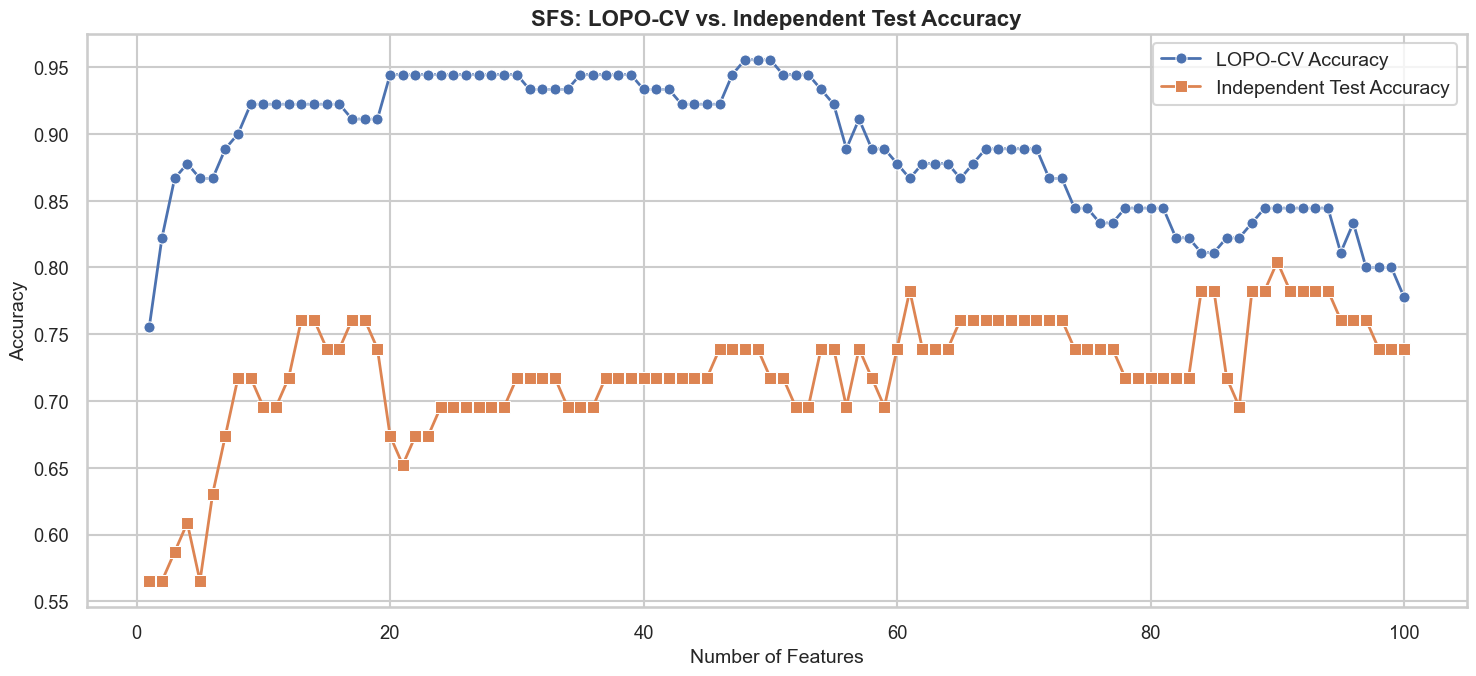

In [14]:
sfs_steps = [record['step'] for record in sfs_history]
sfs_cv_scores = [record['cv_score'] for record in sfs_history]
sfs_ind_test_scores = [record['ind_test_acc'] for record in sfs_test_history]


sns.set_theme(style="whitegrid", context="talk", font_scale=0.8)
plt.figure(figsize=(15, 7))
sns.lineplot(x=sfs_steps, y=sfs_cv_scores, marker="o", markersize=8, lw=2, label="LOPO-CV Accuracy")
sns.lineplot(x=sfs_steps, y=sfs_ind_test_scores, marker="s", markersize=8, lw=2, label="Independent Test Accuracy")
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("SFS: LOPO-CV vs. Independent Test Accuracy", fontsize=16, fontweight="bold")
plt.legend(fontsize=14)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/sfs_cv_ind_test_accuracy_curve.png", dpi=300)
plt.show()


[Summary of SFS Results]
Highest LOOCV Accuracy: 95.6% at step 48 features
    Corresponding Independent Test Accuracy: 73.9%
Highest Independent Test Accuracy: 80.4% at step 90 features
    Corresponding LOOCV Accuracy: 84.4%


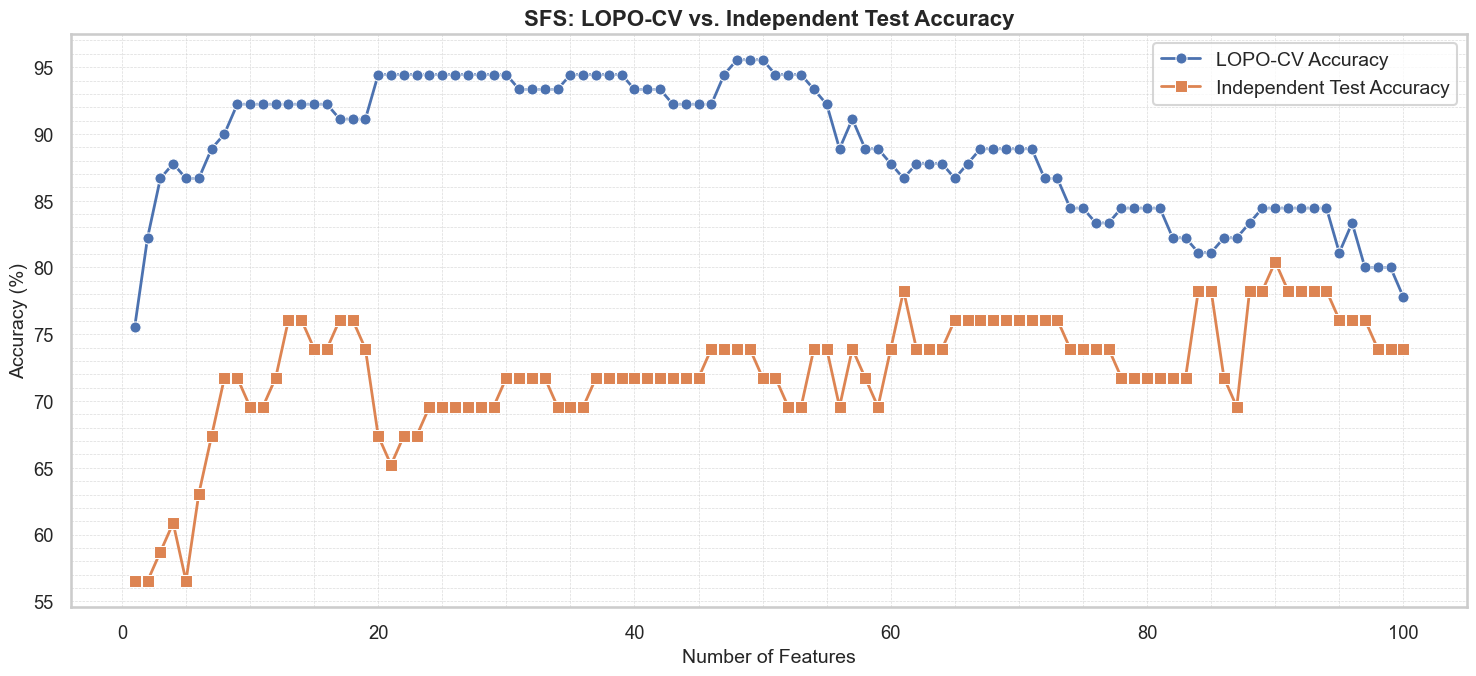

In [15]:
sfs_steps = [record['step'] for record in sfs_test_history]
sfs_cv_scores = [record['cv_score'] for record in sfs_test_history]
sfs_ind_test_scores = [record['ind_test_acc'] for record in sfs_test_history]


sfs_cv_scores_pct = [score * 100 for score in sfs_cv_scores]
sfs_ind_test_scores_pct = [score * 100 for score in sfs_ind_test_scores]


sfs_steps_arr = np.array(sfs_steps)
sfs_cv_arr = np.array(sfs_cv_scores_pct)
sfs_ind_test_arr = np.array(sfs_ind_test_scores_pct)


max_cv_index = int(np.argmax(sfs_cv_arr))
max_cv_step = sfs_steps_arr[max_cv_index]
max_cv_accuracy = sfs_cv_arr[max_cv_index]
corresponding_ind_test_at_max_cv = sfs_ind_test_arr[max_cv_index]


max_ind_test_index = int(np.argmax(sfs_ind_test_arr))
max_ind_test_step = sfs_steps_arr[max_ind_test_index]
max_ind_test_accuracy = sfs_ind_test_arr[max_ind_test_index]
corresponding_cv_at_max_ind_test = sfs_cv_arr[max_ind_test_index]

print("\n[Summary of SFS Results]")
print(f"Highest LOOCV Accuracy: {max_cv_accuracy:.1f}% at step {max_cv_step} features")
print(f"    Corresponding Independent Test Accuracy: {corresponding_ind_test_at_max_cv:.1f}%")
print(f"Highest Independent Test Accuracy: {max_ind_test_accuracy:.1f}% at step {max_ind_test_step} features")
print(f"    Corresponding LOOCV Accuracy: {corresponding_cv_at_max_ind_test:.1f}%")


sns.set_theme(style="whitegrid", context="talk", font_scale=0.8)
plt.figure(figsize=(15, 7))

sns.lineplot(x=sfs_steps, y=sfs_cv_scores_pct, marker="o", markersize=8, lw=2, label="LOPO-CV Accuracy")
sns.lineplot(x=sfs_steps, y=sfs_ind_test_scores_pct, marker="s", markersize=8, lw=2, label="Independent Test Accuracy")

plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("SFS: LOPO-CV vs. Independent Test Accuracy", fontsize=16, fontweight="bold")
plt.legend(fontsize=14)


plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
# plt.savefig("../result/BD_MDD/sfs_cv_ind_test_accuracy_curve.png", dpi=300)
plt.show()

##### plot

Highest LOPO-CV: 95.6% at 48 features; test = 73.9%
At 100 features: LOPO-CV = 77.8%, test = 73.9%


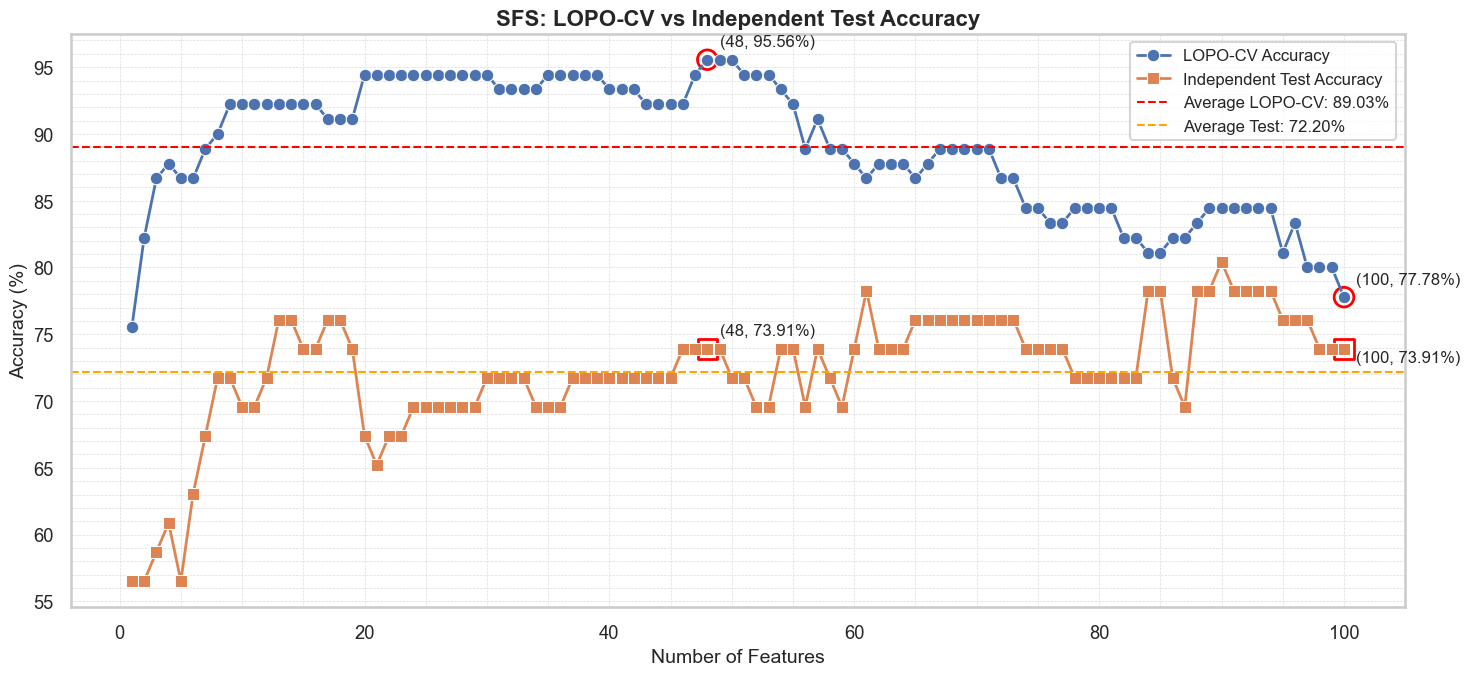

In [ ]:
# extract data from history
sfs_steps       = [record['step'] for record in sfs_test_history]
sfs_cv_scores   = [record['cv_score'] for record in sfs_test_history]
sfs_test_scores = [record['ind_test_acc'] for record in sfs_test_history]
sfs_ind_test_scores = [record['ind_test_acc'] for record in sfs_test_history]

# convert to percentages
cv_pct   = np.array(sfs_cv_scores)  * 100
test_pct = np.array(sfs_test_scores)* 100
steps    = np.array(sfs_steps)

# find LOPO-CV maximum
max_cv_idx     = int(np.argmax(cv_pct))
max_cv_step    = steps[max_cv_idx]
max_cv_value   = cv_pct[max_cv_idx]
test_at_max_cv = test_pct[max_cv_idx]

# find values at 100 features if present
if 100 in steps:
    idx_100     = int(np.where(steps == 100)[0][0])
    cv_at_100   = cv_pct[idx_100]
    test_at_100 = test_pct[idx_100]
else:
    idx_100 = None

# compute means
mean_cv   = cv_pct.mean()
mean_test = test_pct.mean()

# print summary
print(f"Highest LOPO-CV: {max_cv_value:.1f}% at {max_cv_step} features; test = {test_at_max_cv:.1f}%")
if idx_100 is not None:
    print(f"At 100 features: LOPO-CV = {cv_at_100:.1f}%, test = {test_at_100:.1f}%")
else:
    print("No record for 100 features")

# plot
sns.set_theme(style="whitegrid", context="talk", font_scale=0.8)
plt.figure(figsize=(15, 7))

# plot curves with original markers
sns.lineplot(x=steps, y=cv_pct,   marker="o", lw=2, label="LOPO-CV Accuracy")
sns.lineplot(x=steps, y=test_pct, marker="s", lw=2, label="Independent Test Accuracy")

# annotate LOPO-CV max point
plt.text(
    max_cv_step + 1, max_cv_value + 1,
    f"({max_cv_step}, {max_cv_value:.2f}%)",
    fontsize=12
)
plt.text(
    max_cv_step + 1, test_at_max_cv + 1,
    f"({max_cv_step}, {test_at_max_cv:.2f}%)",
    fontsize=12
)

# annotate 100-feature point if exists
if idx_100 is not None:
    plt.text(
        100 + 1, cv_at_100 + 1,
        f"(100, {cv_at_100:.2f}%)",
        fontsize=12
    )
    plt.text(
        100 + 1, test_at_100 - 1,
        f"(100, {test_at_100:.2f}%)",
        fontsize=12
    )


# LOPO-CV max point
plt.scatter(
    max_cv_step, max_cv_value,
    s=200, facecolors='none', edgecolors='red', linewidths=2, marker='o'
)
# corresponding Independent Test at max CV
plt.scatter(
    max_cv_step, test_at_max_cv,
    s=200, facecolors='none', edgecolors='red', linewidths=2, marker='s'
)


# 100-features points
if idx_100 is not None:
    # LOPO-CV at 100
    plt.scatter(
        100, cv_at_100,
        s=200, facecolors='none', edgecolors='red', linewidths=2, marker='o'
    )
    # Independent Test at 100
    plt.scatter(
        100, test_at_100,
        s=200, facecolors='none', edgecolors='red', linewidths=2, marker='s'
    )




# plot mean lines
plt.axhline(mean_cv,   linestyle='--', linewidth=1.5, label=f"Average LOPO-CV: {mean_cv:.2f}%", color='red')
plt.axhline(mean_test, linestyle='--', linewidth=1.5, label=f"Average Test: {mean_test:.2f}%", color='orange')

# labels and legend
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Accuracy (%)",        fontsize=14)
plt.title("SFS: LOPO-CV vs Independent Test Accuracy", fontsize=16, fontweight="bold")
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/MDD_HC/sfs_overall.png", dpi=300)
plt.show()


##### average result

In [19]:
# average accuracy of LOOCV
cv_acc_mean = np.mean(sfs_cv_scores) * 100

# highesrt accuracy of LOOCV
cv_acc_max = np.max(sfs_cv_scores) * 100

# average accuracy of independent test set
ind_test_acc_mean = np.mean(sfs_ind_test_scores) * 100

# highest accuracy of independent test set
ind_test_acc_max = np.max(sfs_ind_test_scores) * 100



print("\n[Summary of SFS Results]")
print(f"Average LOOCV Accuracy: {cv_acc_mean:.2f}%")
print(f"Highest LOOCV Accuracy: {cv_acc_max:.2f}%")
print(f"Average Independent Test Accuracy: {ind_test_acc_mean:.2f}%")
print(f"Highest Independent Test Accuracy: {ind_test_acc_max:.2f}%")


[Summary of SFS Results]
Average LOOCV Accuracy: 89.03%
Highest LOOCV Accuracy: 95.56%
Average Independent Test Accuracy: 72.20%
Highest Independent Test Accuracy: 80.43%


##### channel names

In [11]:
eloc29_path = "../電極通道/BD_MDD_HC_29_test.loc"
eloc29 = mne.channels.read_custom_montage(eloc29_path)
ch_names = eloc29.ch_names

In [12]:
def decode_candidate(original_idx, ch_names, frequency_bands=["delta", "theta", "alpha", "betalow", "betahigh", "gamma"]):
    
    len_coh = 406
    len_pli = 406
    len_ste = 812
    coh_end = 6 * len_coh              # 2436
    pli_end = coh_end + 6 * len_pli    # 4872
    ste_end = pli_end + 6 * len_ste    # 9744
    
    if original_idx < coh_end:
        modality = "COH"
        pos = original_idx
        band_idx = pos // len_coh      # 0 ~ 5
        inner_idx = pos % len_coh      # 0 ~ 405
        band = frequency_bands[band_idx]
        r, c = np.triu_indices(len(ch_names), k=1)
        ch1 = ch_names[r[inner_idx]]
        ch2 = ch_names[c[inner_idx]]
        return f"FC Type: {modality}, Band: {band}, Electrodes: {ch1} - {ch2}"
    elif original_idx < pli_end:
        modality = "PLI"
        pos = original_idx - coh_end
        band_idx = pos // len_pli
        inner_idx = pos % len_pli
        band = frequency_bands[band_idx]
        r, c = np.triu_indices(len(ch_names), k=1)
        ch1 = ch_names[r[inner_idx]]
        ch2 = ch_names[c[inner_idx]]
        return f"FC Type: {modality}, Band: {band}, Electrodes: {ch1} - {ch2}"
    elif original_idx < ste_end:
        modality = "STE"
        pos = original_idx - pli_end
        band_idx = pos // len_ste
        inner_idx = pos % len_ste
        band = frequency_bands[band_idx]
        ste_pairs = [(i, j) for i in range(len(ch_names)) for j in range(len(ch_names)) if i != j]
        i, j = ste_pairs[inner_idx]
        return f"FC Type: {modality}, Band: {band}, Direction: {ch_names[i]} -> {ch_names[j]}"
    else:
        return "Index out of range"

def decode_final_feature(candidate_idx, top_100_idx, ch_names, frequency_bands=["delta", "theta", "alpha", "betalow", "betahigh", "gamma"]):
    full_idx = top_100_idx[candidate_idx]
    return decode_candidate(full_idx, ch_names, frequency_bands)


In [19]:
final_subset_candidate = best_overall["subset"]
print("\n[Result] SFS Optimal feature subset:", final_subset_candidate)


decoded_features = []
modality_counts = {"COH": [], "PLI": [], "STE": []}
for candidate in final_subset_candidate:
    description = decode_final_feature(candidate, top_100_idx, ch_names)
    decoded_features.append(description)

    if "COH" in description:
        modality_counts["COH"].append(description)
    elif "PLI" in description:
        modality_counts["PLI"].append(description)
    elif "STE" in description:
        modality_counts["STE"].append(description)

print("\nDecoded Feature Descriptions:")
for desc in decoded_features:
    print(desc)

print("\nCounts and Details in Final Subset:")
for modality, desc_list in modality_counts.items():
    print(f"{modality}: {len(desc_list)} features")
    for d in desc_list:
        print("  ", d)



[Result] SFS Optimal feature subset: [6, 75, 3, 7, 2, 11, 9, 26, 90, 1, 13, 17, 28, 30, 42, 55, 62, 4, 34, 74, 38, 43, 68, 88, 18, 15, 25, 50, 54, 71, 40, 73, 93, 97, 19, 32, 46, 87, 48, 8, 84, 22, 5, 20, 21, 10, 12, 56]

Decoded Feature Descriptions:
FC Type: COH, Band: betalow, Electrodes: F3 - Fz
FC Type: PLI, Band: theta, Electrodes: Fp1 - T4
FC Type: STE, Band: betalow, Direction: Fp2 -> Fz
FC Type: STE, Band: alpha, Direction: F3 -> Fz
FC Type: STE, Band: betalow, Direction: F3 -> Fz
FC Type: PLI, Band: delta, Electrodes: T3 - F3
FC Type: PLI, Band: delta, Electrodes: T5 - T4
FC Type: COH, Band: delta, Electrodes: Cp3 - Fp1
FC Type: STE, Band: betalow, Direction: Cp3 -> C3
FC Type: STE, Band: gamma, Direction: F3 -> Fz
FC Type: STE, Band: gamma, Direction: Fp2 -> Fz
FC Type: PLI, Band: delta, Electrodes: T5 - Fc4
FC Type: STE, Band: betalow, Direction: O2 -> P4
FC Type: STE, Band: alpha, Direction: Fp2 -> Fz
FC Type: STE, Band: betahigh, Direction: Fp2 -> Fz
FC Type: STE, Band: 

##### independent test

In [13]:
with open("../result/MDD_HC/best_overall.pkl", 'rb') as f:
    best_overall = pickle.load(f)


with open("../result/MDD_HC/sfs_history.pkl", 'rb') as f:
    sfs_history = pickle.load(f)

In [14]:
final_subset = best_overall['subset']
print("\n[Result] SFS Optimal feature subset：", final_subset)

X_train_final = X_train_reduced[:, final_subset]
X_test_final  = X_test_reduced[:, final_subset]

final_svm = SVC(**best_overall['best_params'])
final_svm.fit(X_train_final, y_train)

y_pred_test = final_svm.predict(X_test_final)
test_acc = np.mean(y_pred_test == y_test)
print(f"\n[Ind. Test Result] Accuracy = {test_acc:.6f}")


[Result] SFS Optimal feature subset： [6, 75, 3, 7, 2, 11, 9, 26, 90, 1, 13, 17, 28, 30, 42, 55, 62, 4, 34, 74, 38, 43, 68, 88, 18, 15, 25, 50, 54, 71, 40, 73, 93, 97, 19, 32, 46, 87, 48, 8, 84, 22, 5, 20, 21, 10, 12, 56]

[Ind. Test Result] Accuracy = 0.739130


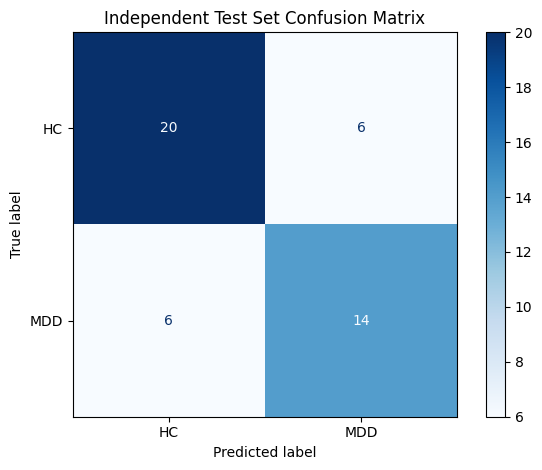

In [15]:
sns.reset_defaults()

cm = confusion_matrix(y_test, y_pred_test)
disp_t = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
disp_t.plot(cmap=plt.cm.Blues)
plt.title("Independent Test Set Confusion Matrix")
plt.tight_layout()
# plt.savefig("../result/BD_MDD/independent_test_confusion_matrix.png")
plt.show()

##### save result

In [ ]:
results = {
    'best_subset': best_overall['subset'],
    'cv_accuracy': best_overall['cv_score'],
    'best_params': best_overall['best_params'],
    'best_step': best_overall['step'],
    'sfs_history': sfs_history,
    'sfs_cv_curve': {
        'steps': sfs_steps,
        'cv_scores': sfs_cv_scores
    },
    'independent_test_accuracy': test_acc,
    'confusion_matrix': cm
}

with open("../result/MDD_HC/sfs_final_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\n[Saved] Final results saved to 'sfs_final_results.pkl'")


[Saved] Final results saved to 'sfs_final_results.pkl'


In [ ]:
with open("../result/MDD_HC/best_overall.pkl", "wb") as f:
    pickle.dump(best_overall, f)

with open("../result/MDD_HC/sfs_history.pkl", "wb") as f:
    pickle.dump(sfs_history, f)

##### top 10 features subset

In [20]:
best_overall_10 = {
    'subset' : sfs_history[99]['subset'],
    'cv_score' : sfs_history[99]['cv_score'],
    'best_params' : sfs_history[99]['best_params'],
    'step' : sfs_history[99]['step']
}

In [21]:
print("Accuracy:", best_overall_10['cv_score'])
print("Best params:", best_overall_10['best_params'])   
print("Step:", best_overall_10['step'])
print("Subset:", best_overall_10['subset'])

Accuracy: 0.7777777777777778
Best params: {'C': 1, 'gamma': 0.053535523746494146, 'kernel': 'rbf'}
Step: 100
Subset: [6, 75, 3, 7, 2, 11, 9, 26, 90, 1, 13, 17, 28, 30, 42, 55, 62, 4, 34, 74, 38, 43, 68, 88, 18, 15, 25, 50, 54, 71, 40, 73, 93, 97, 19, 32, 46, 87, 48, 8, 84, 22, 5, 20, 21, 10, 12, 56, 45, 65, 24, 64, 36, 76, 51, 57, 85, 89, 41, 39, 37, 81, 16, 72, 58, 44, 69, 27, 29, 82, 14, 33, 53, 0, 23, 31, 60, 52, 49, 83, 92, 47, 67, 35, 86, 79, 63, 98, 66, 61, 70, 78, 94, 96, 91, 95, 59, 80, 99, 77]


In [22]:
print("ind. test accuracy:", sfs_test_history[79]['ind_test_acc'])
print("ind. test subset:", sfs_test_history[79]['subset'])
print("ind. test params:", sfs_test_history[79]['best_params'])
print("ind. test step:", sfs_test_history[79]['step'])

ind. test accuracy: 0.717391304347826
ind. test subset: [6, 75, 3, 7, 2, 11, 9, 26, 90, 1, 13, 17, 28, 30, 42, 55, 62, 4, 34, 74, 38, 43, 68, 88, 18, 15, 25, 50, 54, 71, 40, 73, 93, 97, 19, 32, 46, 87, 48, 8, 84, 22, 5, 20, 21, 10, 12, 56, 45, 65, 24, 64, 36, 76, 51, 57, 85, 89, 41, 39, 37, 81, 16, 72, 58, 44, 69, 27, 29, 82, 14, 33, 53, 0, 23, 31, 60, 52, 49, 83]
ind. test params: {'C': 1000, 'kernel': 'linear'}
ind. test step: 80



[Result] SFS Optimal feature subset： [6, 75, 3, 7, 2, 11, 9, 26, 90, 1, 13, 17, 28, 30, 42, 55, 62, 4, 34, 74, 38, 43, 68, 88, 18, 15, 25, 50, 54, 71, 40, 73, 93, 97, 19, 32, 46, 87, 48, 8, 84, 22, 5, 20, 21, 10, 12, 56, 45, 65, 24, 64, 36, 76, 51, 57, 85, 89, 41, 39, 37, 81, 16, 72, 58, 44, 69, 27, 29, 82, 14, 33, 53, 0, 23, 31, 60, 52, 49, 83, 92, 47, 67, 35, 86, 79, 63, 98, 66, 61, 70, 78, 94, 96, 91, 95, 59, 80, 99, 77]

[Ind. Test Result] Accuracy = 0.739130


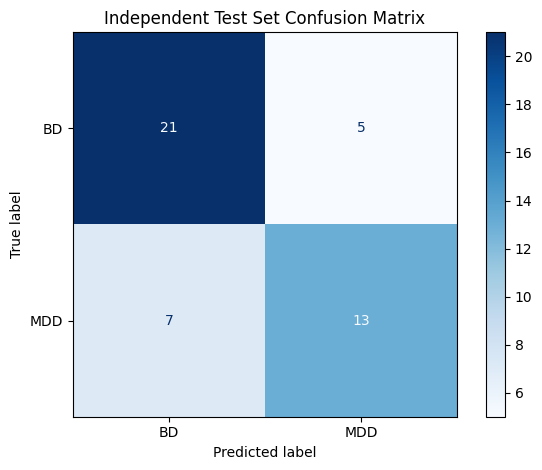

In [23]:
final_subset = best_overall_10['subset']
print("\n[Result] SFS Optimal feature subset：", final_subset)

X_train_final = X_train_reduced[:, final_subset]
X_test_final  = X_test_reduced[:, final_subset]

final_svm = SVC(**best_overall_10['best_params'])
final_svm.fit(X_train_final, y_train)

y_pred_test = final_svm.predict(X_test_final)
test_acc = np.mean(y_pred_test == y_test)
print(f"\n[Ind. Test Result] Accuracy = {test_acc:.6f}")

sns.reset_defaults()
cm = confusion_matrix(y_test, y_pred_test)
disp_t = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["BD", "MDD"])
disp_t.plot(cmap=plt.cm.Blues)
plt.title("Independent Test Set Confusion Matrix")
plt.tight_layout()
plt.show()

##### top 10 features subset channel name

In [ ]:
# 10 features name
final_subset_10 = best_overall_10['subset']
print("\n[Result] SFS Optimal feature subset：", final_subset_10)
decoded_features_10 = []
modality_counts_10 = {"COH": [], "PLI": [], "STE": []}  
for candidate in final_subset_10:
    description = decode_final_feature(candidate, top_100_idx, ch_names)
    decoded_features_10.append(description)

    if "COH" in description:
        modality_counts_10["COH"].append(description)
    elif "PLI" in description:
        modality_counts_10["PLI"].append(description)
    elif "STE" in description:
        modality_counts_10["STE"].append(description)
print("\nDecoded Feature Descriptions:")
for desc in decoded_features_10:
    print(desc)
print("\nCounts and Details in Final Subset:")
for modality, desc_list in modality_counts_10.items():
    print(f"{modality}: {len(desc_list)} features")
    for d in desc_list:
        print("  ", d)


[Result] SFS Optimal feature subset： [6, 75, 3, 7, 2, 11, 9, 26, 90, 1, 13, 17, 28, 30, 42, 55, 62, 4, 34, 74, 38, 43, 68, 88, 18, 15, 25, 50, 54, 71, 40, 73, 93, 97, 19, 32, 46, 87, 48, 8, 84, 22, 5, 20, 21, 10, 12, 56, 45, 65, 24, 64, 36, 76, 51, 57, 85, 89, 41, 39, 37, 81, 16, 72, 58, 44, 69, 27, 29, 82, 14, 33, 53, 0, 23, 31, 60, 52, 49, 83, 92, 47, 67, 35, 86, 79, 63, 98, 66, 61, 70, 78, 94, 96, 91, 95, 59, 80, 99, 77]

Decoded Feature Descriptions:
FC Type: COH, Band: betalow, Electrodes: F3 - Fz
FC Type: PLI, Band: theta, Electrodes: Fp1 - T4
FC Type: STE, Band: betalow, Direction: Fp2 -> Fz
FC Type: STE, Band: alpha, Direction: F3 -> Fz
FC Type: STE, Band: betalow, Direction: F3 -> Fz
FC Type: PLI, Band: delta, Electrodes: T3 - F3
FC Type: PLI, Band: delta, Electrodes: T5 - T4
FC Type: COH, Band: delta, Electrodes: Cp3 - Fp1
FC Type: STE, Band: betalow, Direction: Cp3 -> C3
FC Type: STE, Band: gamma, Direction: F3 -> Fz
FC Type: STE, Band: gamma, Direction: Fp2 -> Fz
FC Type: 

##### save result

In [37]:
with open("../result/MDD_HC/best_overall_5.pkl", "wb") as f:
    pickle.dump(best_overall_10, f)